In [30]:
# 1. Các thư viện cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
from pyFTS.common import FLR
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Fix the import in the pyFTS library if necessary
# In the file '/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py', change:
# from pandas import datetime
# to:
# from pandas import Timestamp

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-usi8rksu
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-usi8rksu
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


# **Chia train test theo tỉ lệ 8:2**

In [32]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('Eth.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [33]:
# 3. Chia train, test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


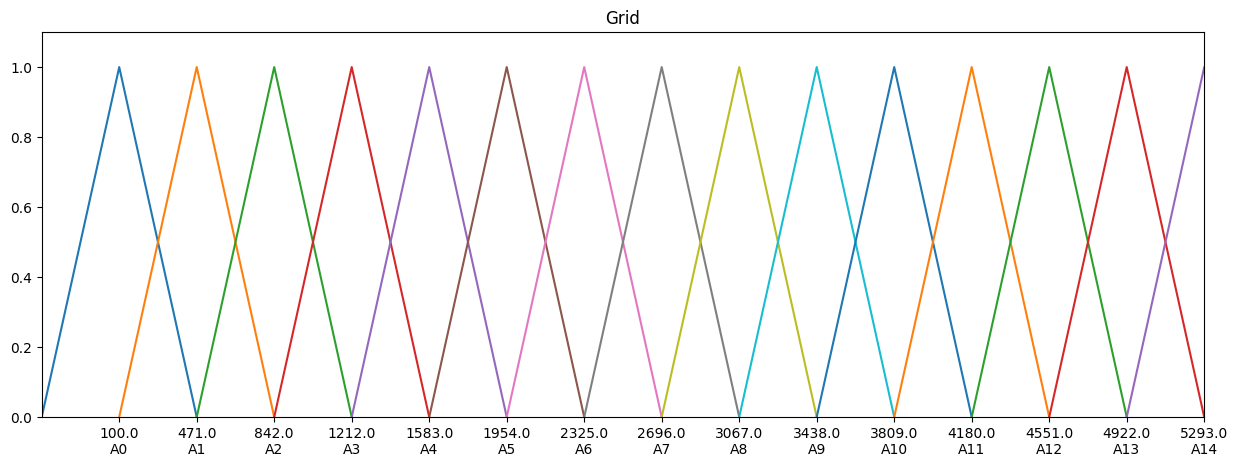

In [34]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [35]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [36]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A0', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A4', 'A6 -> A5', 'A5 -> A3', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A7 -> A5', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A11 -> A9', 'A10 -> A8', 'A8 -> A6', 'A9 -> A6', 'A9 -> A7', 'A8 -> A11', 'A11 -> A8', 'A10 -> A12', 'A11 -> A12', 'A12 -> A10', 'A12 -> A11', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [37]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A2,A0 -> A0,A1
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A0,A2 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A1,A2 -> A0,A1,A2,A3
A2,A1 -> A0,A1,A2,A3
A2,A2 -> A1,A2,A3,A4
A1,A3 -> A2,A3
A2,A4 -> A2,A3,A4
A2,A3 -> A2,A3,A4
A3,A2 -> A2,A3,A4
A4,A2 -> A2,A3,A4
A3,A3 -> A2,A3,A4,A5
A3,A4 -> A2,A3,A4,A5
A4,A3 -> A2,A3,A4,A5
A4,A4 -> A2,A3,A4,A5,A6
A3,A5 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A4,A5 -> A3,A4,A5,A6
A5,A4 -> A3,A4,A5,A6
A5,A5 -> A3,A4,A5,A6,A7
A4,A6 -> A4,A5,A6
A6,A4 -> A4,A5,A6
A6,A5 -> A4,A5,A6,A7
A5,A6 -> A4,A5,A6,A7,A8
A6,A6 -> A4,A5,A6,A7,A8
A7,A5 -> A5,A6,A7
A5,A7 -> A5,A6,A7,A8
A6,A7 -> A5,A6,A7,A8
A7,A6 -> A5,A6,A7,A8
A8,A6 -> A5,A6,A7,A8
A8,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8
A7,A8 -> A6,A7,A8,A9
A9,A6 -> A7,A8
A9,A7 -> A6,A7,A8,A9
A7,A9 -> A7,A8,A9
A8,A8 -> A10,A11,A6,A7,A8,A9
A8,A9 -> A10,A11,A6,A7,A8,A9
A9,A8 -> A10,A11,A6,A7,A8,A9
A9,A9 -> A10,A11,A6,A7,A8,A9
A8,A10 -> A10,A8,A9
A10,A8 -> A10,A8,A9
A9,A10 -> A10,A11,A8,A9
A10,A9 ->

In [38]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [39]:
# 10. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 94.39520904618057
Testing RMSE: 108.22730777136277
Testing MAPE: 0.04353097790024545


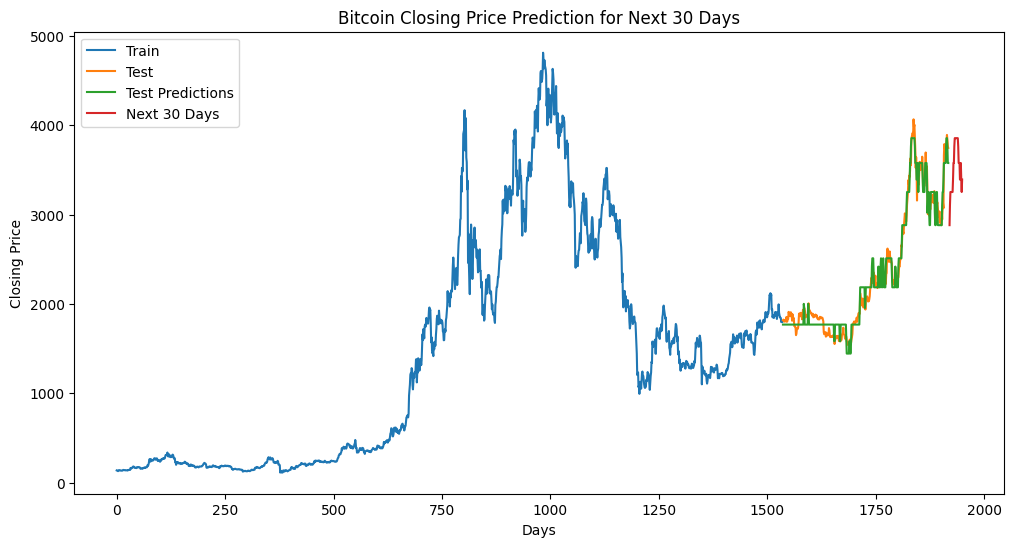

Predicted closing prices for the next 30 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655]


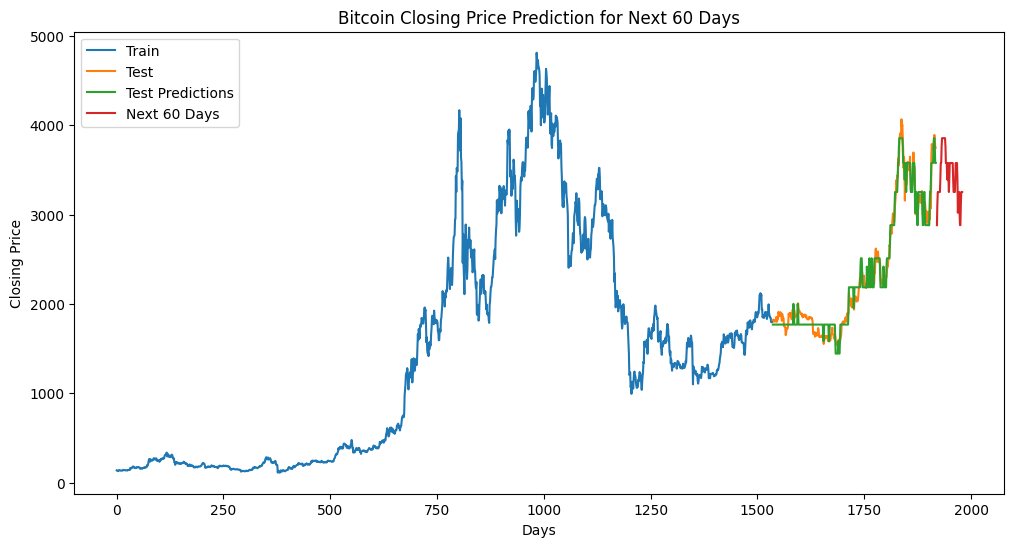

Predicted closing prices for the next 60 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655
 3577.50344856 3577.50344856 3577.50344856 3577.50344856 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3021.03014252
 3113.77569353 3252.89402004 3252.89402004 3021.03014252 2881.91181601
 2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004]


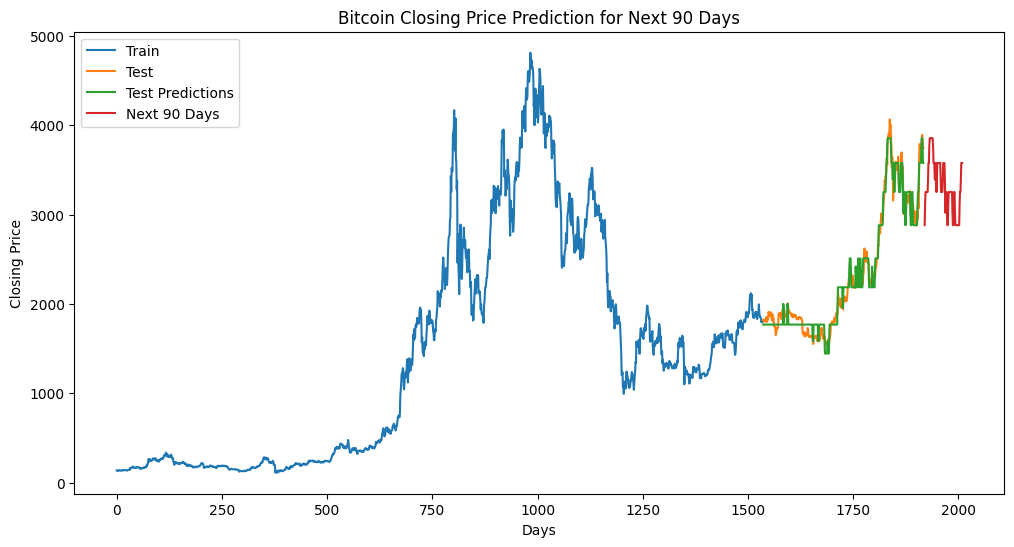

Predicted closing prices for the next 90 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655
 3577.50344856 3577.50344856 3577.50344856 3577.50344856 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3021.03014252
 3113.77569353 3252.89402004 3252.89402004 3021.03014252 2881.91181601
 2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3021.03014252 2

In [40]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())


# **Chia train test theo tỉ lệ 7:3**

In [41]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('Eth.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [42]:
# 3. Chia train, test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


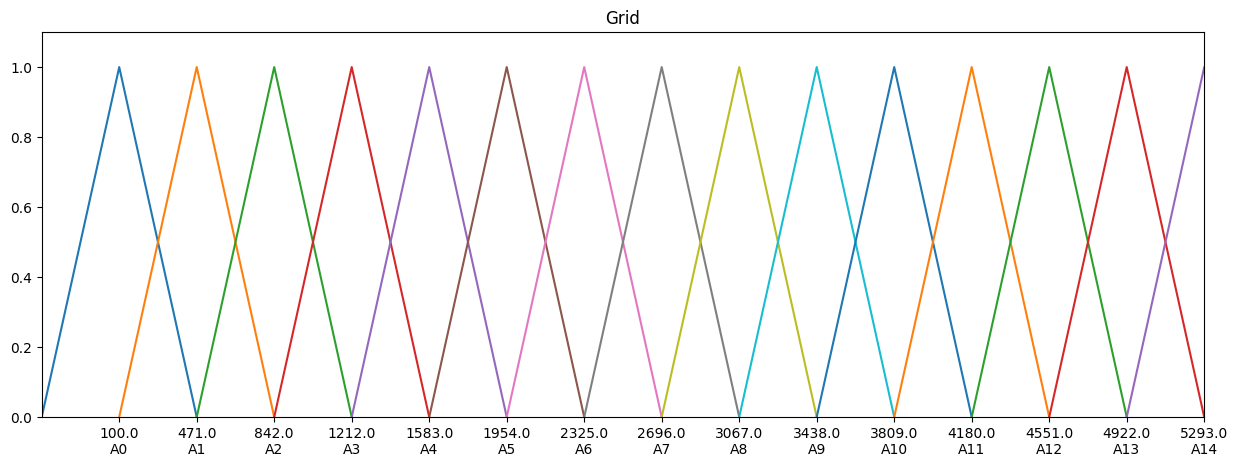

In [43]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [44]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [45]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A0', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A4', 'A6 -> A5', 'A5 -> A3', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A7 -> A5', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A11 -> A9', 'A10 -> A8', 'A8 -> A6', 'A9 -> A6', 'A9 -> A7', 'A8 -> A11', 'A11 -> A8', 'A10 -> A12', 'A11 -> A12', 'A12 -> A10', 'A12 -> A11', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [46]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A2,A0 -> A0,A1
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A0,A2 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A1,A2 -> A0,A1,A2,A3
A2,A1 -> A0,A1,A2,A3
A2,A2 -> A1,A2,A3,A4
A1,A3 -> A2,A3
A2,A4 -> A2,A3,A4
A2,A3 -> A2,A3,A4
A3,A2 -> A2,A3,A4
A4,A2 -> A2,A3,A4
A3,A3 -> A2,A3,A4,A5
A3,A4 -> A2,A3,A4,A5
A4,A3 -> A2,A3,A4,A5
A4,A4 -> A2,A3,A4,A5,A6
A3,A5 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A4,A5 -> A3,A4,A5,A6
A5,A4 -> A3,A4,A5,A6
A5,A5 -> A3,A4,A5,A6,A7
A4,A6 -> A4,A5,A6
A6,A4 -> A4,A5,A6
A6,A5 -> A4,A5,A6,A7
A5,A6 -> A4,A5,A6,A7,A8
A6,A6 -> A4,A5,A6,A7,A8
A7,A5 -> A5,A6,A7
A5,A7 -> A5,A6,A7,A8
A6,A7 -> A5,A6,A7,A8
A7,A6 -> A5,A6,A7,A8
A8,A6 -> A5,A6,A7,A8
A8,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8
A7,A8 -> A6,A7,A8,A9
A9,A6 -> A7,A8
A9,A7 -> A6,A7,A8,A9
A7,A9 -> A7,A8,A9
A8,A8 -> A10,A11,A6,A7,A8,A9
A8,A9 -> A10,A11,A6,A7,A8,A9
A9,A8 -> A10,A11,A6,A7,A8,A9
A9,A9 -> A10,A11,A6,A7,A8,A9
A8,A10 -> A10,A8,A9
A10,A8 -> A10,A8,A9
A9,A10 -> A10,A11,A8,A9
A10,A9 ->

In [47]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [48]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 97.34454489455344
Testing RMSE: 112.30648743250339
Testing MAPE: 0.050981961622867576


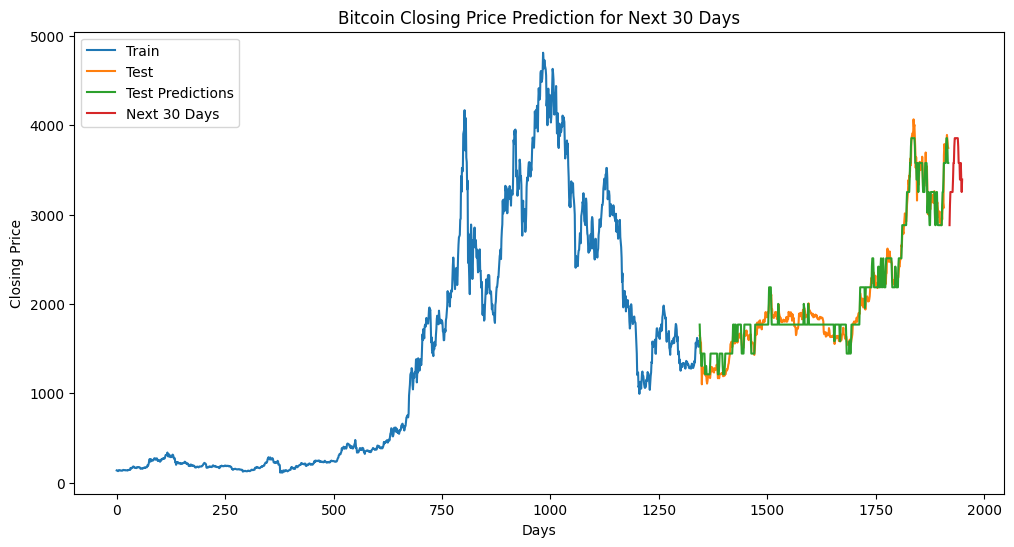

Predicted closing prices for the next 30 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655]


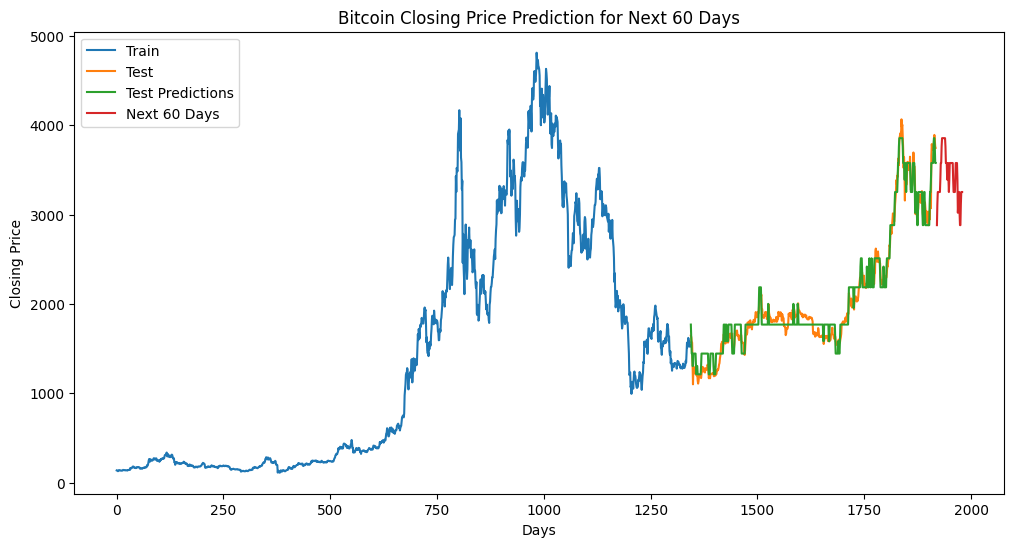

Predicted closing prices for the next 60 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655
 3577.50344856 3577.50344856 3577.50344856 3577.50344856 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3021.03014252
 3113.77569353 3252.89402004 3252.89402004 3021.03014252 2881.91181601
 2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004]


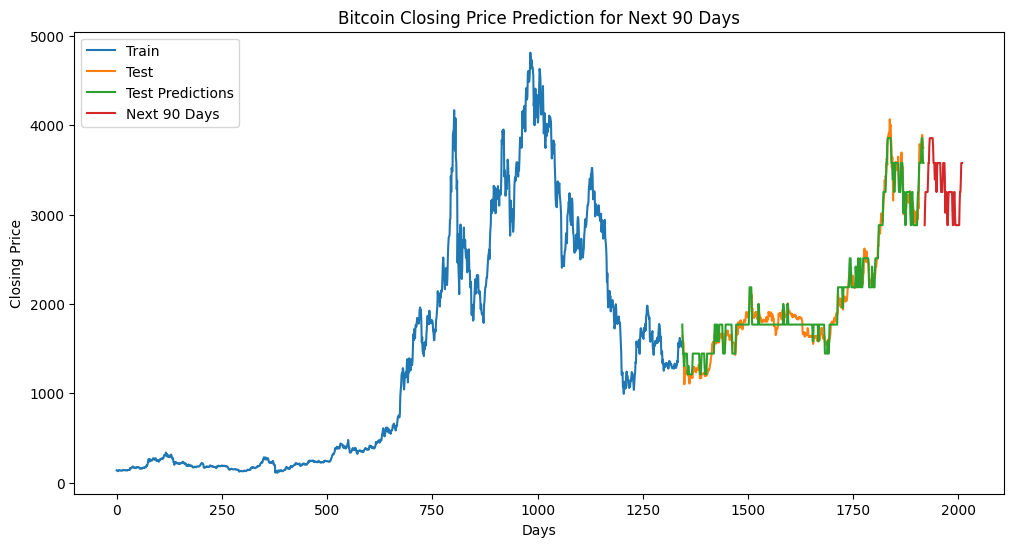

Predicted closing prices for the next 90 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655
 3577.50344856 3577.50344856 3577.50344856 3577.50344856 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3021.03014252
 3113.77569353 3252.89402004 3252.89402004 3021.03014252 2881.91181601
 2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3021.03014252 2

In [49]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test theo tỉ lệ 6:4**

In [50]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('Eth.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [51]:
# 3. Chia train, test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


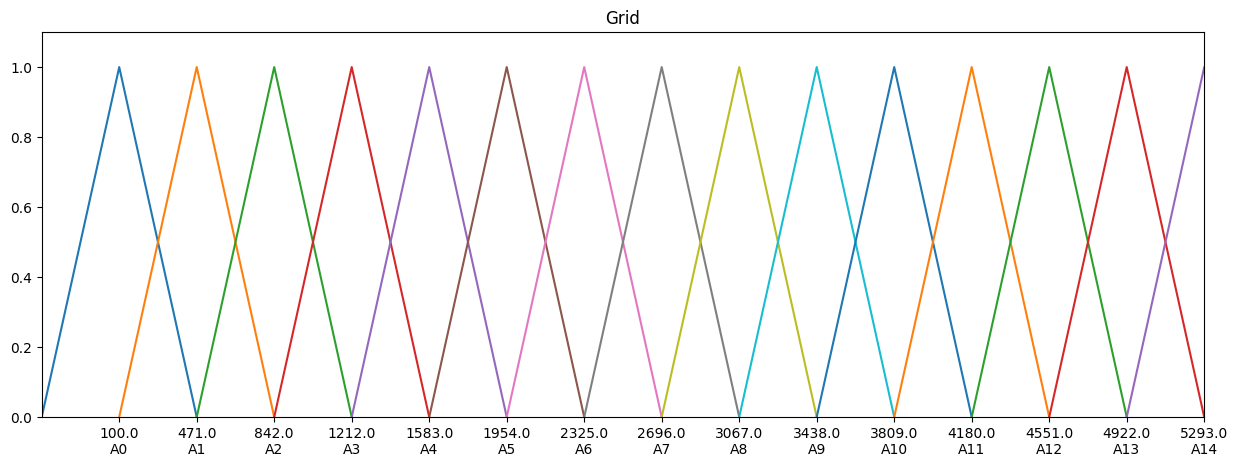

In [52]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [53]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [54]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A0', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A4', 'A6 -> A5', 'A5 -> A3', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A7 -> A5', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A11 -> A9', 'A10 -> A8', 'A8 -> A6', 'A9 -> A6', 'A9 -> A7', 'A8 -> A11', 'A11 -> A8', 'A10 -> A12', 'A11 -> A12', 'A12 -> A10', 'A12 -> A11', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [55]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A2,A0 -> A0,A1
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A0,A2 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A1,A2 -> A0,A1,A2,A3
A2,A1 -> A0,A1,A2,A3
A2,A2 -> A1,A2,A3,A4
A1,A3 -> A2,A3
A2,A4 -> A2,A3,A4
A2,A3 -> A2,A3,A4
A3,A2 -> A2,A3,A4
A4,A2 -> A2,A3,A4
A3,A3 -> A2,A3,A4,A5
A3,A4 -> A2,A3,A4,A5
A4,A3 -> A2,A3,A4,A5
A4,A4 -> A2,A3,A4,A5,A6
A3,A5 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A4,A5 -> A3,A4,A5,A6
A5,A4 -> A3,A4,A5,A6
A5,A5 -> A3,A4,A5,A6,A7
A4,A6 -> A4,A5,A6
A6,A4 -> A4,A5,A6
A6,A5 -> A4,A5,A6,A7
A5,A6 -> A4,A5,A6,A7,A8
A6,A6 -> A4,A5,A6,A7,A8
A7,A5 -> A5,A6,A7
A6,A7 -> A5,A6,A7,A8
A7,A6 -> A5,A6,A7,A8
A8,A6 -> A5,A6,A7,A8
A8,A7 -> A5,A6,A7,A8,A9
A5,A7 -> A6,A7,A8
A7,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8
A7,A8 -> A6,A7,A8,A9
A9,A6 -> A7,A8
A9,A7 -> A6,A7,A8,A9
A7,A9 -> A7,A8,A9
A8,A8 -> A10,A11,A6,A7,A8,A9
A8,A9 -> A10,A11,A6,A7,A8,A9
A9,A8 -> A10,A11,A6,A7,A8,A9
A9,A9 -> A10,A11,A6,A7,A8,A9
A8,A10 -> A10,A8,A9
A10,A8 -> A10,A8,A9
A9,A10 -> A10,A11,A8,A9
A10,A9 -> A1

In [56]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [57]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 98.52246244082949
Testing RMSE: 113.86287395835147
Testing MAPE: 0.054210492985764275


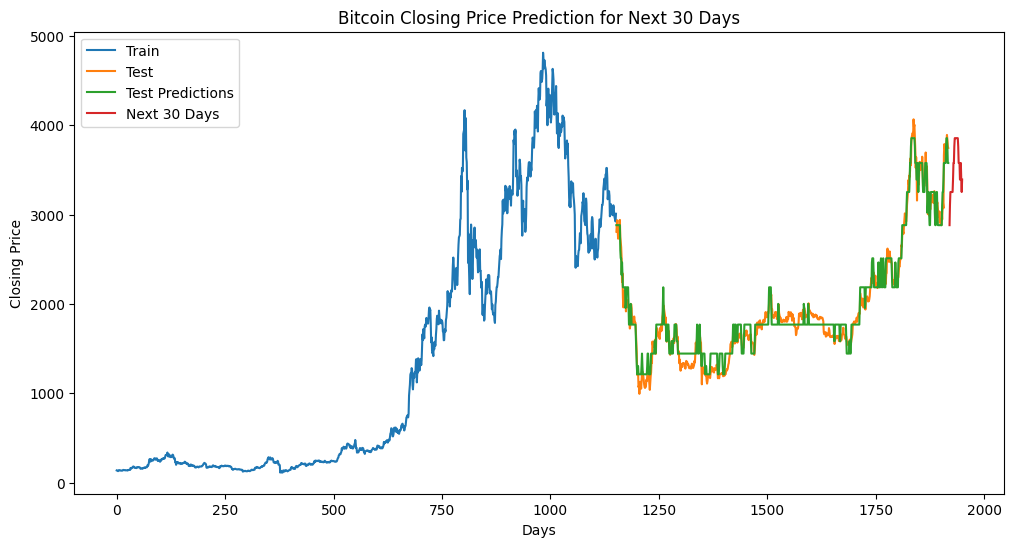

Predicted closing prices for the next 30 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655]


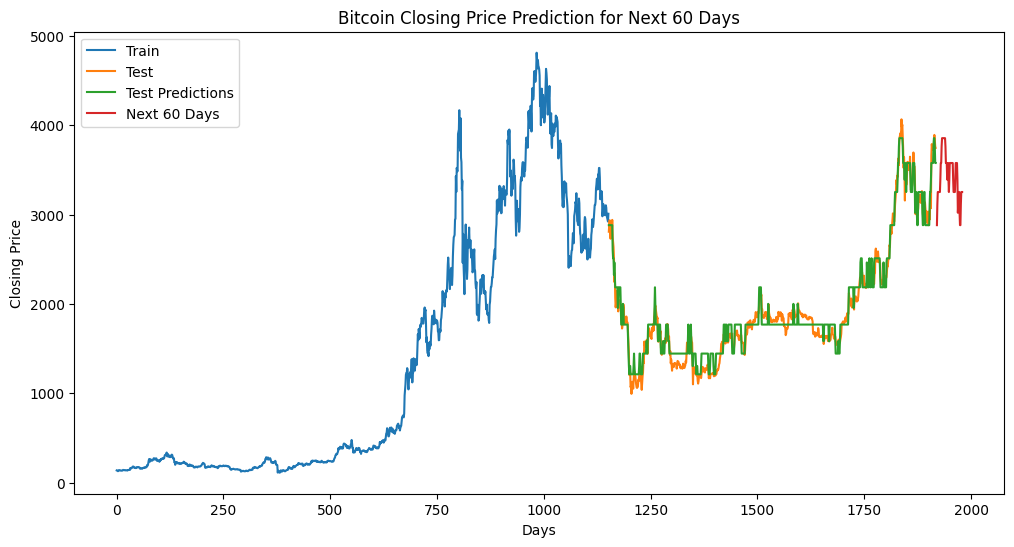

Predicted closing prices for the next 60 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655
 3577.50344856 3577.50344856 3577.50344856 3577.50344856 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3021.03014252
 3113.77569353 3252.89402004 3252.89402004 3021.03014252 2881.91181601
 2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004]


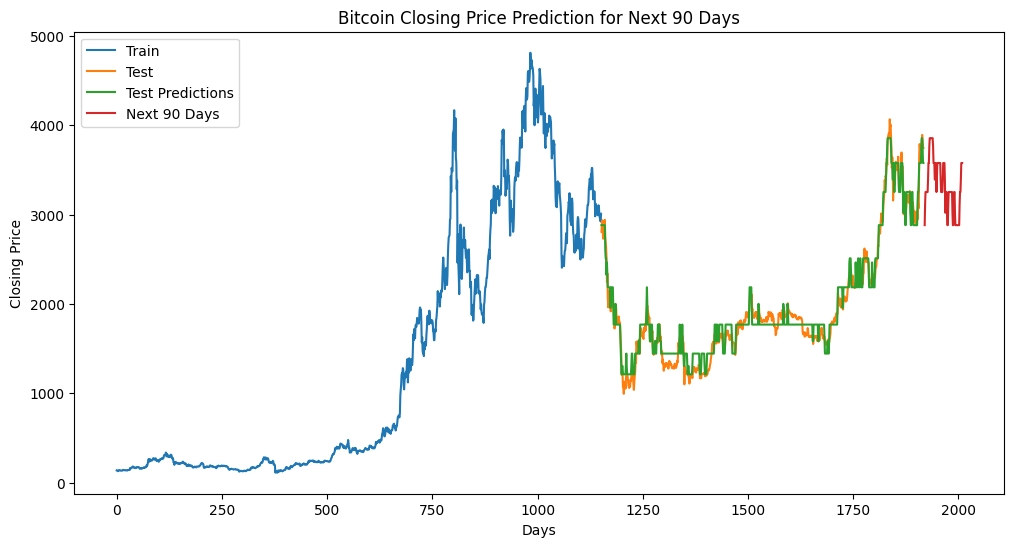

Predicted closing prices for the next 90 days:
[2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3762.99455058 3855.74010159 3855.74010159 3855.74010159
 3855.74010159 3855.74010159 3855.74010159 3855.74010159 3855.74010159
 3762.99455058 3577.50344856 3577.50344856 3577.50344856 3392.01234655
 3392.01234655 3577.50344856 3392.01234655 3252.89402004 3392.01234655
 3577.50344856 3577.50344856 3577.50344856 3577.50344856 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3392.01234655 3577.50344856
 3577.50344856 3577.50344856 3577.50344856 3392.01234655 3021.03014252
 3113.77569353 3252.89402004 3252.89402004 3021.03014252 2881.91181601
 2881.91181601 3113.77569353 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3252.89402004 3252.89402004 3252.89402004 3252.89402004
 3252.89402004 3021.03014252 2

In [58]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())